In [5]:
'''
In this notebook i will select data from a specific area and time period. Lets use the data from 2015 to 2025 and 
the area of 18N to 22N and 91W to 86W. For that time period, i want to know how correlated is the temperature in that area 
with another grid points, Also i want to know how correlated is the precipitation in that area with another grid points.
Finally i want to know how is the covariance between temperature and precipitation in that area.

Daniela Risaro
July 2025
'''

import os 
import numpy as np 
import xarray as xr 
import pandas as pd 
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

## select data from 2015 to 2025 and 18N to 22N and 91W to 86W.

data_dir = "../data/raw/"
output_dir = "../data/processed/"

os.makedirs(output_dir, exist_ok=True)

files_tmax = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "tmax" in file])
files_tmin = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "tmin" in file])
files_precipitation = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "precipitation" in file])

wanted_years = list(range(2015, 2026))

lat_min, lat_max = 18, 22 
lon_min, lon_max = -91, -86  


print(files_tmax)
# Load maximum temperature
tmax_datasets = [xr.open_dataset(data_dir + f) for f in files_tmax 
                if int(f.split("daily_")[1].split("_area")[0]) in wanted_years]

temperature_max = xr.concat(tmax_datasets, dim="valid_time")
temperature_max = temperature_max["t2m"] - 273.15

# Load minimum temperature
tmin_datasets = [xr.open_dataset(data_dir + f) for f in files_tmin 
                if int(f.split("daily_")[1].split("_area")[0]) in wanted_years]
temperature_min = xr.concat(tmin_datasets, dim="valid_time")
temperature_min = temperature_min["t2m"] - 273.15

# Load precipitation
precip_datasets = [xr.open_dataset(data_dir + f) for f in files_precipitation 
                  if int(f.split("daily_")[1].split("_area")[0]) in wanted_years]
precipitation = xr.concat(precip_datasets, dim="valid_time")
precipitation = precipitation["tp"]  

# Select regions
tmax_region = temperature_max.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    valid_time=slice("2015-01-01", "2025-06-30")
)

tmin_region = temperature_min.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    valid_time=slice("2015-01-01", "2025-06-30")
)

precip_region = precipitation.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max), 
    valid_time=slice("2015-01-01", "2025-06-30")
)



['era5_tmax_daily_1960_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1961_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1962_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1963_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1964_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1965_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1966_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1967_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1968_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1969_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1970_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1971_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1972_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1973_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1974_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1975_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1976_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1977_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1978_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_1979_area_45N_-95W_5S_-65E.nc', 'era5_tmax_daily_19

In [6]:

ref_lat = 20.645092
ref_lon = -87.085771

# Get reference points for all variables
ref_tmax = tmax_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')
ref_tmin = tmin_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')
ref_precip = precip_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')

print(f"Actual grid point coordinates used:")
print(f"Latitude: {float(ref_tmax.latitude.values):.3f}°N")
print(f"Longitude: {float(ref_tmax.longitude.values):.3f}°W")

# Calculate correlations for both temperature variables
tmax_correlations = xr.corr(ref_tmax, tmax_region, dim='valid_time')
tmin_correlations = xr.corr(ref_tmin, tmin_region, dim='valid_time')

#precip_correlations = xr.corr(ref_precip, precip_region, dim='valid_time')



Actual grid point coordinates used:
Latitude: 20.750°N
Longitude: -87.000°W


In [8]:
from scipy import stats

precip_correlations = xr.zeros_like(precip_region.isel(valid_time=0))

ref_precip_values = ref_precip.values

for lat in precip_region.latitude:
    for lon in precip_region.longitude:
        target_precip = precip_region.sel(latitude=lat, longitude=lon)
        target_precip_values = target_precip.values
        
        rho, _ = stats.spearmanr(ref_precip_values, target_precip_values, nan_policy='omit')
        
        precip_correlations.loc[dict(latitude=lat, longitude=lon)] = rho

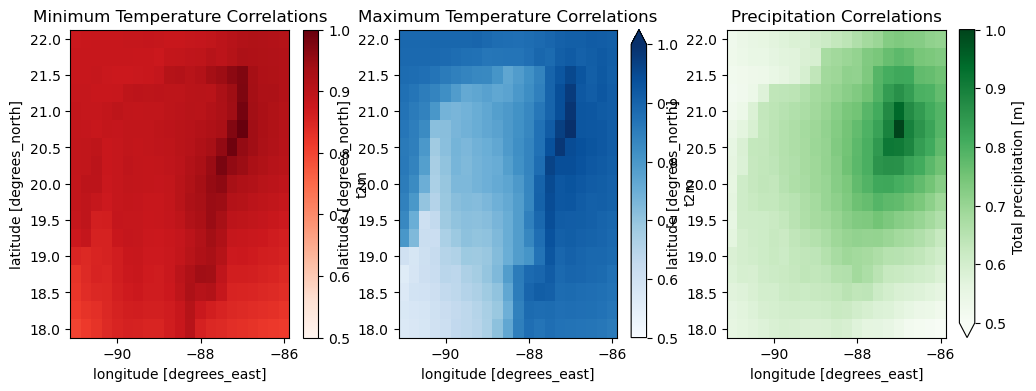

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
tmin_correlations.plot(ax=ax[0], cmap='Reds', vmin=0.5, vmax=1)
tmax_correlations.plot(ax=ax[1], cmap='Blues', vmin=0.5, vmax=1)
precip_correlations.plot(ax=ax[2], cmap='Greens', vmin=0.5, vmax=1)

ax[0].set_title('Minimum Temperature Correlations')
ax[1].set_title('Maximum Temperature Correlations')
ax[2].set_title('Precipitation Correlations')

plt.show()

In [10]:

df = pd.DataFrame({
    'date': ref_tmax.valid_time.values,
    'tmax': ref_tmax.values,
    'tmin': ref_tmin.values,
    'precipitation': ref_precip.values,
    'diurnal_range': ref_tmax.values - ref_tmin.values
})

df = df.sort_values('date')

# Export to CSV
output_path = '../outputs/tulum_temp_precip_timeseries.csv'
df.to_csv(output_path, index=False)

print(f"Data exported to: {output_path}")
print("\nFirst few rows of the data:")
print(df.head())

Data exported to: ../outputs/tulum_temp_precip_timeseries.csv

First few rows of the data:
        date       tmax       tmin  precipitation  diurnal_range
0 2015-01-01  27.231354  23.739716       0.000147       3.491638
1 2015-01-02  27.373688  24.685577       0.000154       2.688110
2 2015-01-03  27.882965  25.665375       0.000223       2.217590
3 2015-01-04  27.771881  25.561584       0.000277       2.210297
4 2015-01-05  27.114166  25.171051       0.000121       1.943115


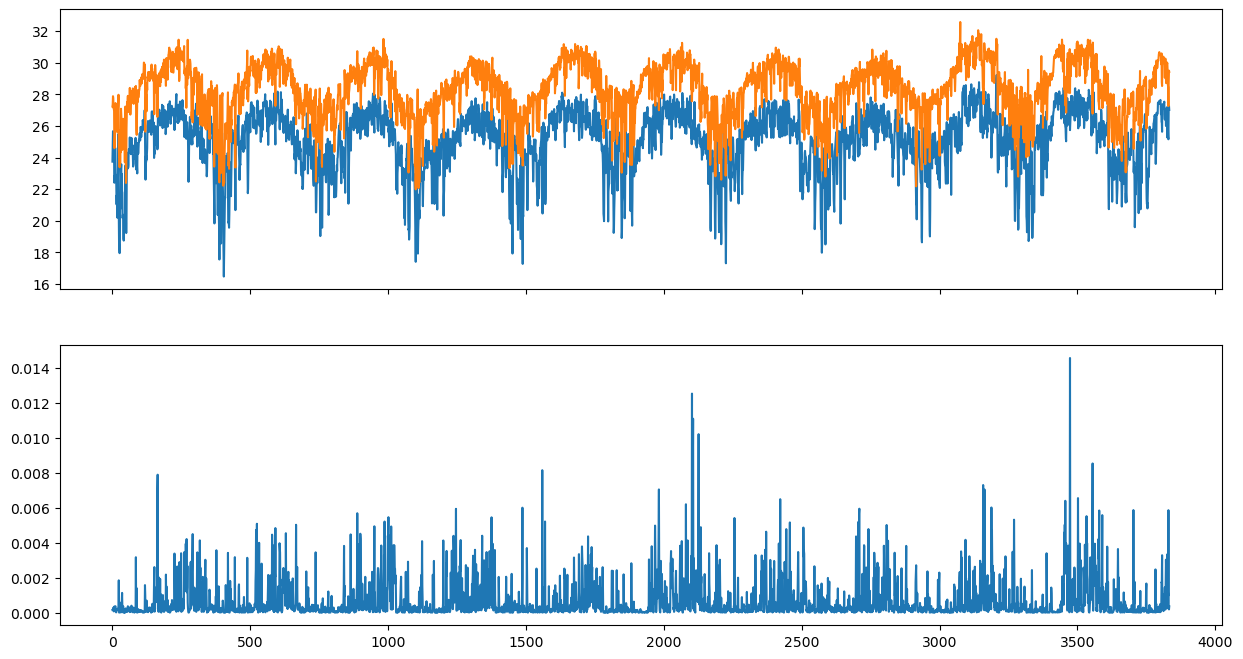

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

df['tmin'].plot(ax=ax[0])
df['tmax'].plot(ax=ax[0])
df['precipitation'].plot(ax=ax[1])
plt.show()

Precipitation Analysis:
Total number of records: 3834

Precipitation Statistics:

All precipitation values:
count    3834.000000
mean        0.000675
std         0.001121
min         0.000000
25%         0.000074
50%         0.000212
75%         0.000717
max         0.014546
Name: precipitation, dtype: float64

Non-zero precipitation values:
count    3.701000e+03
mean     6.990999e-04
std      1.133880e-03
min      4.768372e-07
25%      8.916855e-05
50%      2.250671e-04
75%      7.581711e-04
max      1.454639e-02
Name: precipitation, dtype: float64

Log10(Non-zero precipitation):
count    3701.000000
mean       -3.655348
std         0.762615
min        -6.321630
25%        -4.049788
50%        -3.647688
75%        -3.120233
max        -1.837245
Name: precipitation, dtype: float64

Correlations:
Maximum Temperature vs Precipitation (all data): 0.045
Maximum Temperature vs Log10(Precipitation) (non-zero only): 0.105


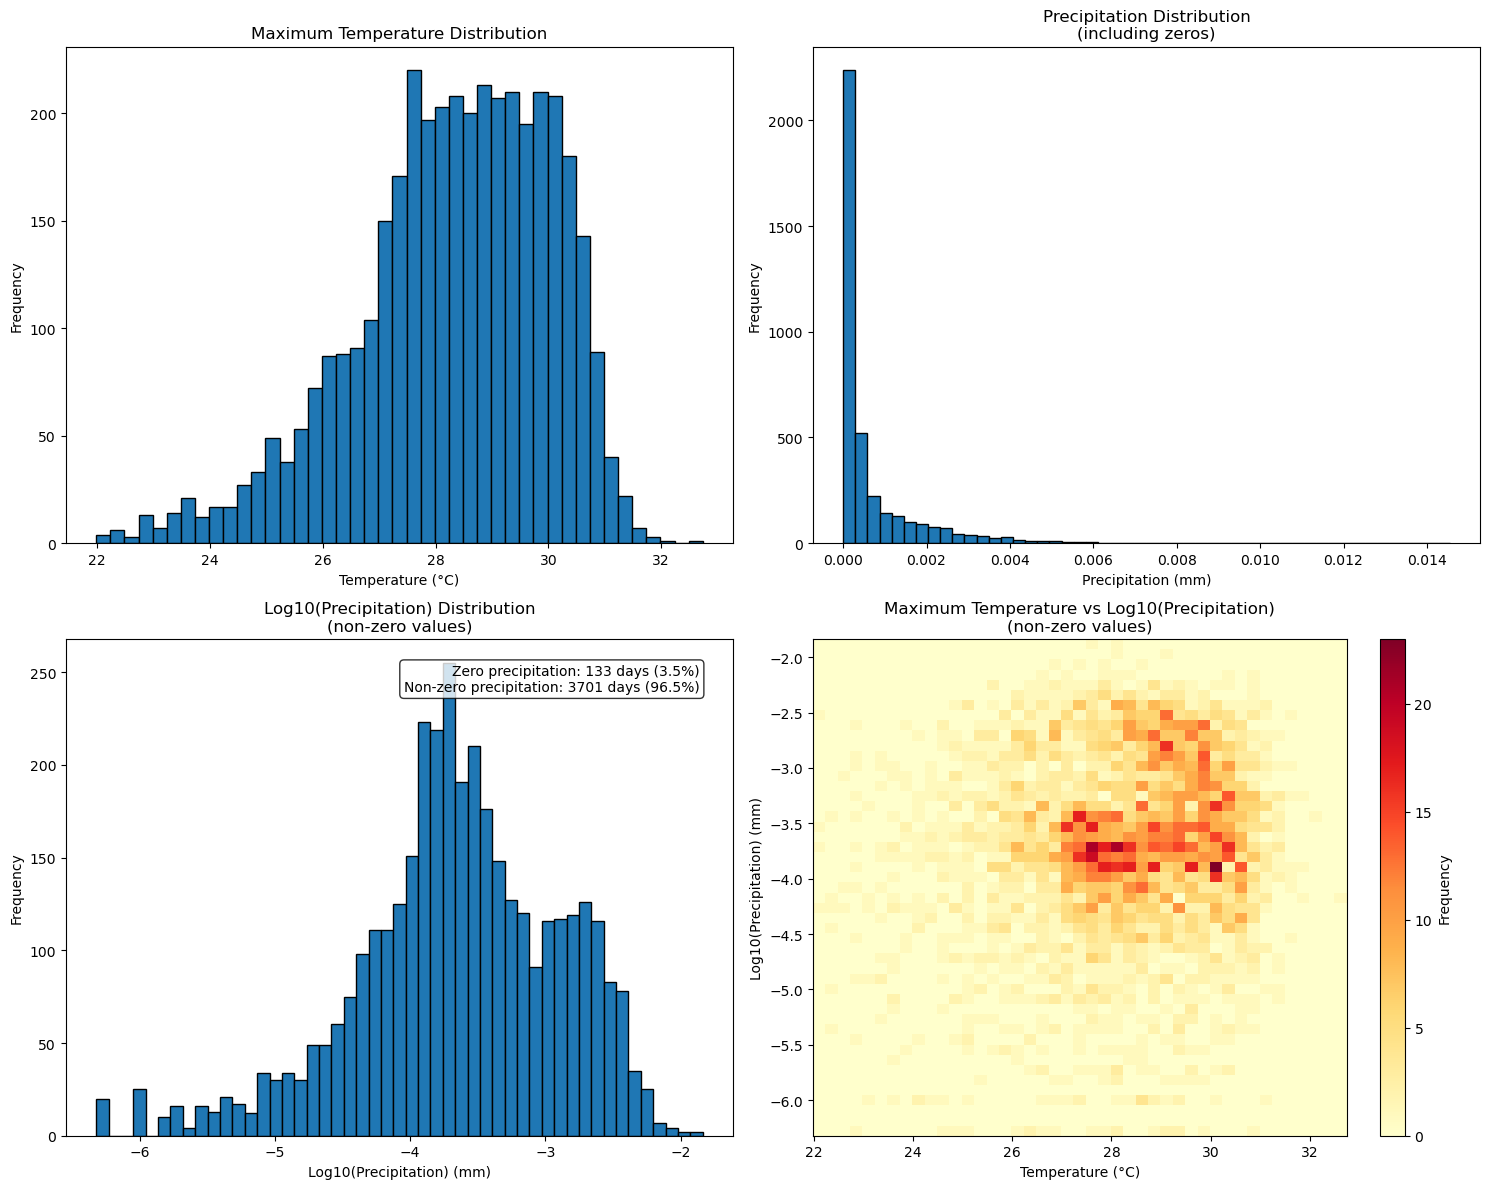

In [11]:
# Analyze precipitation patterns
print("Precipitation Analysis:")
print(f"Total number of records: {len(df)}")

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Temperature distribution (top left)
bins_temp = np.arange(df['tmax'].min(), df['tmax'].max() + 0.25, 0.25)
axes[0,0].hist(df['tmax'].dropna(), bins=bins_temp, edgecolor='black')
axes[0,0].set_title('Maximum Temperature Distribution')
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')

# 2. Original Precipitation Distribution (top right)
non_zero_precip = df[df['precipitation'] > 0]
axes[0,1].hist(df['precipitation'], bins=50, edgecolor='black')
axes[0,1].set_title('Precipitation Distribution\n(including zeros)')
axes[0,1].set_xlabel('Precipitation (mm)')
axes[0,1].set_ylabel('Frequency')

# 3. Log-transformed Precipitation (bottom left)
log_non_zero = np.log10(non_zero_precip['precipitation'])
bins_log_precip = np.linspace(log_non_zero.min(), log_non_zero.max(), 50)
axes[1,0].hist(log_non_zero, bins=bins_log_precip, edgecolor='black')
axes[1,0].set_title('Log10(Precipitation) Distribution\n(non-zero values)')
axes[1,0].set_xlabel('Log10(Precipitation) (mm)')
axes[1,0].set_ylabel('Frequency')

# Add text box with precipitation statistics
zero_count = len(df[df['precipitation'] == 0])
text = (f'Zero precipitation: {zero_count} days ({zero_count/len(df)*100:.1f}%)\n'
        f'Non-zero precipitation: {len(non_zero_precip)} days ({len(non_zero_precip)/len(df)*100:.1f}%)')
axes[1,0].text(0.95, 0.95, text, transform=axes[1,0].transAxes, 
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Temperature vs Precipitation Relationships (bottom right)
h = axes[1,1].hist2d(non_zero_precip['tmax'], log_non_zero, 
                     bins=[bins_temp, bins_log_precip], cmap='YlOrRd')
axes[1,1].set_title('Maximum Temperature vs Log10(Precipitation)\n(non-zero values)')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('Log10(Precipitation) (mm)')
plt.colorbar(h[3], ax=axes[1,1], label='Frequency')

plt.tight_layout()

# Print statistics
print("\nPrecipitation Statistics:")
print("\nAll precipitation values:")
print(df['precipitation'].describe())
print("\nNon-zero precipitation values:")
print(non_zero_precip['precipitation'].describe())
print("\nLog10(Non-zero precipitation):")
print(log_non_zero.describe())

# Calculate correlations both ways
corr_all = df['tmax'].corr(df['precipitation'])
corr_non_zero = non_zero_precip['tmax'].corr(log_non_zero)
print("\nCorrelations:")
print(f"Maximum Temperature vs Precipitation (all data): {corr_all:.3f}")
print(f"Maximum Temperature vs Log10(Precipitation) (non-zero only): {corr_non_zero:.3f}")


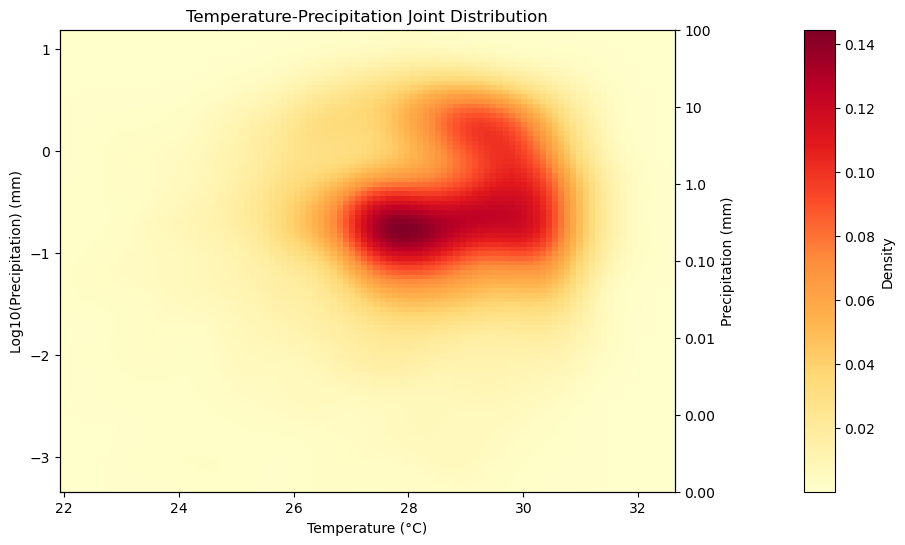

In [13]:
fig = plt.figure(figsize=(10, 6))
gs = plt.GridSpec(1, 2, width_ratios=[20, 1])
ax1 = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# Convert precipitation to mm
log_non_zero_mm = np.log10(non_zero_precip['precipitation'] * 1000)

x_grid = np.linspace(non_zero_precip['tmax'].min(), 
                     non_zero_precip['tmax'].max(), 100)
y_grid = np.linspace(log_non_zero_mm.min(), log_non_zero_mm.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

xy = np.vstack([non_zero_precip['tmax'], log_non_zero_mm])
kde = gaussian_kde(xy, bw_method='scott')

positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

im = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='YlOrRd')
ax1.set_title('Temperature-Precipitation Joint Distribution')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Log10(Precipitation) (mm)')

ax2 = ax1.twinx()
y_min, y_max = ax1.get_ylim()

log_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1)
real_values = 10**log_ticks  # These are now in mm

ax2.set_ylim(ax1.get_ylim())
ax2.set_ylabel('Precipitation (mm)')

tick_labels = []
for v in real_values:
    if v < 1:
        tick_labels.append(f'{v:.2f}')
    elif v < 10:
        tick_labels.append(f'{v:.1f}')
    else:
        tick_labels.append(f'{int(v)}')

ax2.set_yticks(log_ticks)
ax2.set_yticklabels(tick_labels)

plt.colorbar(im, cax=cax, label='Density')
plt.subplots_adjust(wspace=0.4)



Temperature Statistics:

Maximum Temperature:
count    3834.000000
mean       28.319351
std         1.732544
min        21.985382
25%        27.314972
50%        28.507477
75%        29.679901
max        32.583160
Name: tmax, dtype: float64

Minimum Temperature:
count    3834.000000
mean       25.009295
std         1.940702
min        16.463043
25%        24.004555
50%        25.345123
75%        26.395844
max        29.228912
Name: tmin, dtype: float64

Diurnal Temperature Range:
count    3834.000000
mean        3.310056
std         0.919854
min         0.797363
25%         2.724609
50%         3.204468
75%         3.767090
max         8.171875
Name: diurnal_range, dtype: float64

Correlations with precipitation (non-zero values):
Minimum Temperature vs Log10(Precipitation): 0.173
Diurnal Range vs Log10(Precipitation): -0.161


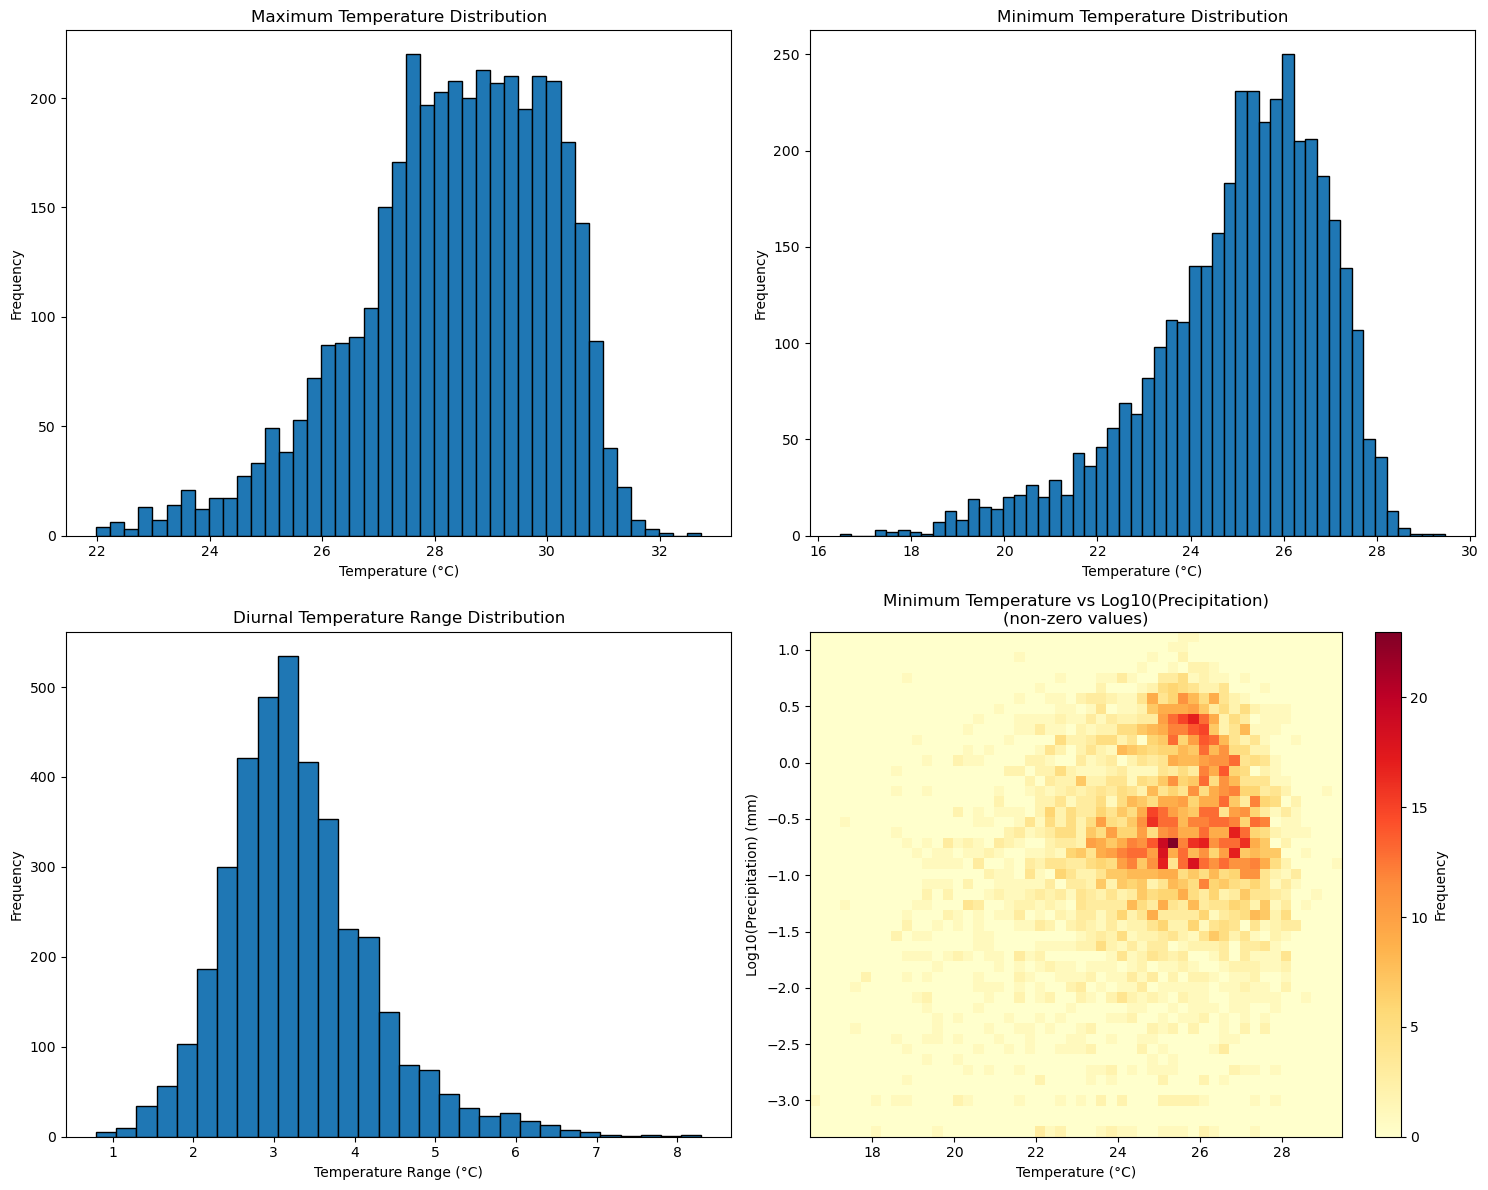

In [ ]:
# Create figure for temperature analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Tmax distribution (top left)
bins_tmax = np.arange(df['tmax'].min(), df['tmax'].max() + 0.25, 0.25)
axes[0,0].hist(df['tmax'].dropna(), bins=bins_tmax, edgecolor='black')
axes[0,0].set_title('Maximum Temperature Distribution')
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')

# 2. Tmin distribution (top right)
bins_tmin = np.arange(df['tmin'].min(), df['tmin'].max() + 0.25, 0.25)
axes[0,1].hist(df['tmin'].dropna(), bins=bins_tmin, edgecolor='black')
axes[0,1].set_title('Minimum Temperature Distribution')
axes[0,1].set_xlabel('Temperature (°C)')
axes[0,1].set_ylabel('Frequency')

# 3. Diurnal range distribution (bottom left)
bins_range = np.arange(df['diurnal_range'].min(), df['diurnal_range'].max() + 0.25, 0.25)
axes[1,0].hist(df['diurnal_range'].dropna(), bins=bins_range, edgecolor='black')
axes[1,0].set_title('Diurnal Temperature Range Distribution')
axes[1,0].set_xlabel('Temperature Range (°C)')
axes[1,0].set_ylabel('Frequency')

# 4. Tmin vs Precipitation (bottom right)
non_zero_precip = df[df['precipitation'] > 0]
log_non_zero = np.log10(non_zero_precip['precipitation'] * 1000)  # Convert to mm
h = axes[1,1].hist2d(non_zero_precip['tmin'], log_non_zero, 
                     bins=[bins_tmin, np.linspace(log_non_zero.min(), log_non_zero.max(), 50)],
                     cmap='YlOrRd')
axes[1,1].set_title('Minimum Temperature vs Log10(Precipitation)\n(non-zero values)')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('Log10(Precipitation) (mm)')
plt.colorbar(h[3], ax=axes[1,1], label='Frequency')

plt.tight_layout()




Number of extreme events (Tmin < p05 and Precip > p95): 1
Percentage of total days: 0.03%


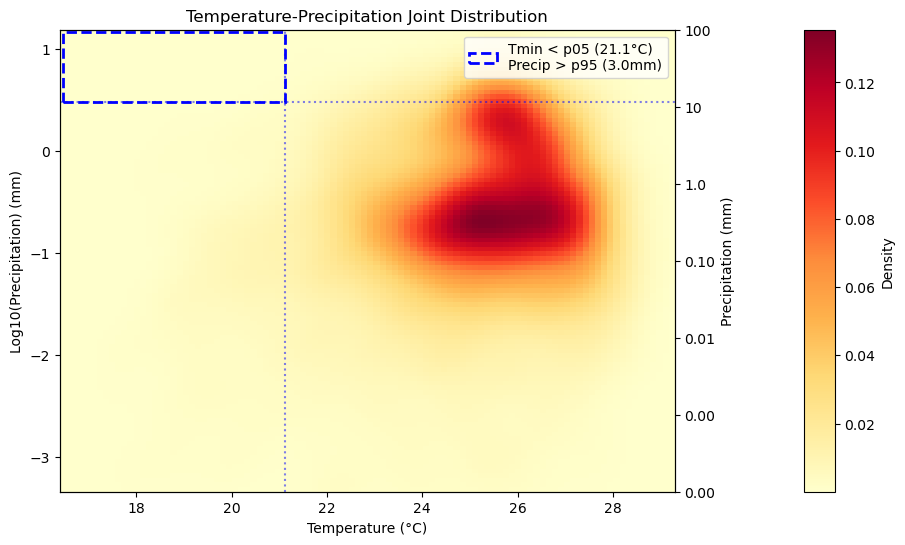

In [14]:
# Calculate percentiles
p05_tmin = np.percentile(df['tmin'], 5)
p95_precip = np.percentile(df['precipitation'] * 1000, 95)  # Convert to mm
log_p95_precip = np.log10(p95_precip)

fig = plt.figure(figsize=(10, 6))
gs = plt.GridSpec(1, 2, width_ratios=[20, 1])
ax1 = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# Convert precipitation to mm
log_non_zero_mm = np.log10(non_zero_precip['precipitation'] * 1000)

x_grid = np.linspace(non_zero_precip['tmin'].min(), 
                     non_zero_precip['tmin'].max(), 100)
y_grid = np.linspace(log_non_zero_mm.min(), log_non_zero_mm.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

xy = np.vstack([non_zero_precip['tmin'], log_non_zero_mm])
kde = gaussian_kde(xy, bw_method='scott')

positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

im = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='YlOrRd')
ax1.set_title('Temperature-Precipitation Joint Distribution')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Log10(Precipitation) (mm)')

# Add rectangle for the extreme quadrant
rect = plt.Rectangle((non_zero_precip['tmin'].min(), log_p95_precip), 
                    p05_tmin - non_zero_precip['tmin'].min(), 
                    log_non_zero_mm.max() - log_p95_precip,
                    fill=False, color='blue', linestyle='--', linewidth=2,
                    label=f'Tmin < p05 ({p05_tmin:.1f}°C)\nPrecip > p95 ({p95_precip:.1f}mm)')
ax1.add_patch(rect)
ax1.legend(loc='upper right')

# Add horizontal and vertical lines for the thresholds
ax1.axhline(y=log_p95_precip, color='blue', linestyle=':', alpha=0.5)
ax1.axvline(x=p05_tmin, color='blue', linestyle=':', alpha=0.5)

ax2 = ax1.twinx()
y_min, y_max = ax1.get_ylim()

log_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1)
real_values = 10**log_ticks  # These are now in mm

ax2.set_ylim(ax1.get_ylim())
ax2.set_ylabel('Precipitation (mm)')

tick_labels = []
for v in real_values:
    if v < 1:
        tick_labels.append(f'{v:.2f}')
    elif v < 10:
        tick_labels.append(f'{v:.1f}')
    else:
        tick_labels.append(f'{int(v)}')

ax2.set_yticks(log_ticks)
ax2.set_yticklabels(tick_labels)

plt.colorbar(im, cax=cax, label='Density')
plt.subplots_adjust(wspace=0.4)

# Print statistics about the extreme events
extreme_events = df[(df['tmin'] < p05_tmin) & (df['precipitation'] * 1000 > p95_precip)]
print(f"\nNumber of extreme events (Tmin < p05 and Precip > p95): {len(extreme_events)}")
print(f"Percentage of total days: {len(extreme_events)/len(df)*100:.2f}%")


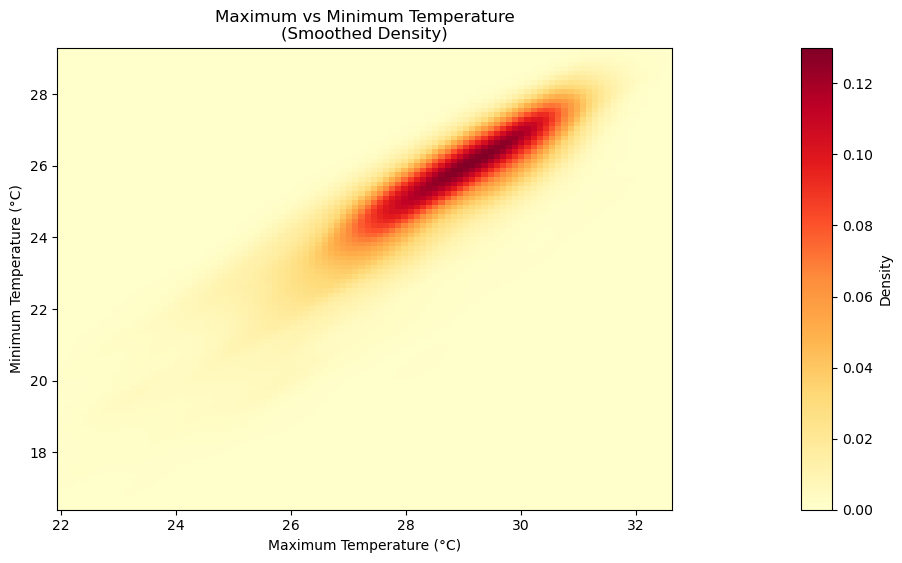

In [ ]:
fig = plt.figure(figsize=(10, 6))
gs = plt.GridSpec(1, 2, width_ratios=[20, 1])
ax1 = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

x_grid = np.linspace(df['tmax'].min(), df['tmax'].max(), 100)
y_grid = np.linspace(df['tmin'].min(), df['tmin'].max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

xy = np.vstack([df['tmax'], df['tmin']])
kde = gaussian_kde(xy, bw_method='scott')

positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

im = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='YlOrRd')
ax1.set_title('Maximum vs Minimum Temperature\n(Smoothed Density)')
ax1.set_xlabel('Maximum Temperature (°C)')
ax1.set_ylabel('Minimum Temperature (°C)')

plt.colorbar(im, cax=cax, label='Density')
plt.subplots_adjust(wspace=0.4)

